# Assignment objective

We have data from Raleigh, NC, where we recently deployed a flyer program in order to increase public awareness of the possibility of taking a Pagaya loan. You objective is to assess the potency of the flyer program in terms of activation by analyzing production and TU data obtained from the town.


# Basic imports 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.proportion import proportions_ztest
from pagayapro.paths.data_paths import ASSIGNMENT1_DATA
import glob
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Data preparation

## Data from TU 

To begin with, upload TUs credit information from the relevant quarter (which is 2018Q3). This data is available in our `s3` path under the name `tu_gen_data2018Q3.parquet`. To get to our `s3` path import `DATA_FILES_PATH` from `pagayapro.paths.data_paths`

In [3]:
from pagayapro.paths.data_paths import DATA_FILES_PATH

read the parquet file from `s3`. Only read the columns ["sequence_num", "credit_score", "listing_term", "int_rate", "loan_amnt", "monthly_pmt", "original_state"]

In [4]:
tu_data= pd.read_parquet(
    os.path.join(DATA_FILES_PATH,"tu_gen_data_2018Q3.parquet"),
                columns = ["sequence_num", "credit_score", 
                           "listing_term", "int_rate" ,
                           "loan_amnt", "monthly_pmt", 
                           "original_state"])

Output the first 5 rows of tu_data

In [5]:
tu_data.head()

,sequence_num,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
id,,,,,,,
adf5219e4cb985352184eb7fa597737e4a9777f7354f7a8a58270da147792561,d0820401b209782dae4284b3dd96b41e08c3e8566fbb33...,814,36.0,7.86,5500.0,172.0,MI
0a0f130443af4c6597bb074942970eaddeb125d398e2cca42175c56befc8a171,2f05cd66cb998e5e55f6f296344b271b2b89b996c7c037...,800,36.0,7.91,20000.0,626.0,NM
4ba9c6a38b650ee06b8b88a48621bd363cdf611e63400c6fc4bbffbd1bf20c47,20bdbfaf0006db032d8a4176add08fd4ef45abfb17c474...,653,36.0,30.51,3674.0,157.0,SD
dae3a344292e07d4b8935a453c37aef01303f21b2f37ccbd1c4408f158533acb,53084498c6bf053a4d1cf309e1b8ec234e503bb1a3dd4e...,623,60.0,23.46,14056.0,400.0,NC
8af2ae2462d012e4d85aa687a16a4f5fb64525928235da43c795f73dc0cadd04,f750c4ecac12ae1c156998ed3dff3f46d2d19f37250074...,627,60.0,25.55,8659.0,257.0,TN


## Activation data 

Your data regarding activation arrives as forms, detailing the loan amount, interest rate offered to the client and whether he or she accepted the offer. These are available on the assignment's `s3` path, which you can import from `pagayapro.path.data_paths` under the name `ASSIGNMENT1_DATA`, in the subdirectory `offers`. Since we are reading multiple files from `s3` we will also import the `s3fs` package which allows us to do just that (similar to `glob`, only for `s3`).

Read all files in the subdirectory `offers` of `ASSIGNMENT1_DATA` whose name contains the substring `raleigh`.

In [6]:
raleigh_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*raleigh*")
    )
)

how many forms are there?


In [11]:
# number of forms:
len(raleigh_forms)

769

Read all the form files and create a table which contains only the last offer given to each borrower. Call this dataframe `raleigh_df`.

In [8]:
raleigh_df= pd.concat(map(pd.read_csv,raleigh_forms))
raleigh_df_no_dup=raleigh_df.sort_values(by='offer_date').groupby('id').last()

How many rows are there in your table? How many distict ids?

In [10]:
# numbers of rows:
len(raleigh_df_no_dup)

8792

In [15]:
# number of distinct id:
len(raleigh_df_no_dup.index.unique())

8792

How can you explain the duplicate ids? Sample 5 ids with multiple lines and display them.

*Answer:* Because we groupby the data, we don't have duplicate ids.

Drop all lines in the dataframe which contain irrelevant information.

In [16]:
raleigh_df_no_dup.describe()

,requested_amount,offered_interest_rate
count,8792.000000,8792.000000
mean,11752.396724,15.524285
std,9534.989444,7.641190
min,500.000000,1.100000
25%,5000.000000,9.850000
50%,9600.000000,13.470000
75%,15000.000000,19.470000
max,200200.000000,39.990000


We didn't find irrelevant information. As you can see teh range of requested_amount and offered_interest_rate looks acceptable. 

What is the average interest rate offered to clients? What is the average among clients who accepted the offer?

In [17]:
# average interest rate offered to clients:
raleigh_df_no_dup['offered_interest_rate'].mean()

15.524284576888082

In [18]:
# average intrest rate among clients who accepted the offer
raleigh_df_no_dup[raleigh_df_no_dup['offer_accepted']==True]['offered_interest_rate'].mean()

15.307480314960628

What is the percentage of activation in this dataframe?

In [19]:
# percentage of activation
raleigh_df_no_dup['offer_accepted'].sum()/len(raleigh_df_no_dup)

0.08666969972702457

Enrich your dataframe with additioanl TU features by merging it with the `tu_data` df. Note that the two dataframe share the `id` and `sequence_num` features.

In [21]:
enriched_raleigh = raleigh_df_no_dup.merge(tu_data,on=['id','sequence_num'])

In [22]:
enriched_raleigh.describe()

,requested_amount,offered_interest_rate,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt
count,8792.000000,8792.000000,8792.000000,8792.000000,8792.000000,8792.000000,8792.000000
mean,11752.396724,15.524285,689.821542,46.635123,15.524285,11752.396724,329.570632
std,9534.989444,7.641190,71.800569,11.922805,7.641190,9534.989444,245.744085
min,500.000000,1.100000,1.000000,36.000000,1.100000,500.000000,18.000000
25%,5000.000000,9.850000,645.000000,36.000000,9.850000,5000.000000,159.000000
50%,9600.000000,13.470000,688.000000,36.000000,13.470000,9600.000000,256.000000
75%,15000.000000,19.470000,735.000000,60.000000,19.470000,15000.000000,428.000000
max,200200.000000,39.990000,845.000000,60.000000,39.990000,200200.000000,3894.000000


What is the average credit score of the clients? What is the average among clients who accepted the offer?

In [23]:
# average credit score of the clients
enriched_raleigh['credit_score'].mean()

689.821542311192

In [24]:
# average credit score among clients who accepted the offe
enriched_raleigh[enriched_raleigh['offer_accepted']]['credit_score'].mean()

702.5446194225722

# Validations

Before we embark on a statistical test, let's do some validations to make sure that the Raleig sample is not somehow distinct from the general population. Our random sample from the general population is the TU data.

Create a histogram to describe the distribution of requested loan amounts in Raleigh and in the general population. Do the distributions look similar? (A good rule-of-thumb for the number of bins to use is the square-root of the number of unique value.)

Text(0, 0.5, 'Density')

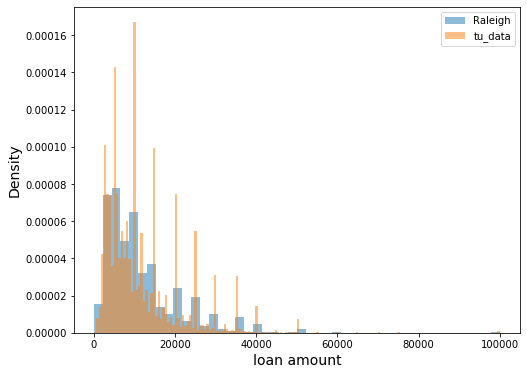

In [26]:
bins=round(len(enriched_raleigh['loan_amnt'].unique())**0.5)
bins1=round(len(tu_data['loan_amnt'].unique())**0.5)

plt.figure(figsize=(8,6))
plt.hist(enriched_raleigh['loan_amnt'], bins=bins, alpha=0.5, label="Raleigh",density=True,range=(0,100000))
plt.hist(tu_data['loan_amnt'], bins=bins1, alpha=0.5, label="tu_data",density=True,range=(0,100000))
plt.legend()
plt.xlabel("loan amount", size=14)
plt.ylabel("Density", size=14)

Describe the loan amount distribution using `sns.distplot` in the Raleigh dataframe and in TU.

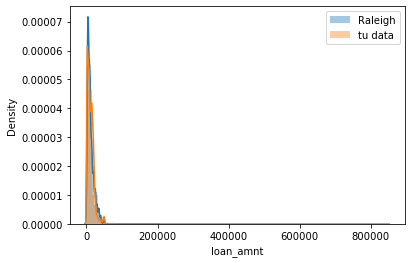

In [47]:
sns.distplot(enriched_raleigh['loan_amnt'],label='Raleigh')
sns.distplot(tu_data['loan_amnt'],label='tu data')
plt.legend()
plt.show()

We also want to verify that the offered interest rate in Raleigh seem similar to those in the general population. 
Create a histogram to describe the distribution of offered interest rates in Raleigh and interest rates in the general population. Do the distributions look similar?

Text(0, 0.5, 'Density')

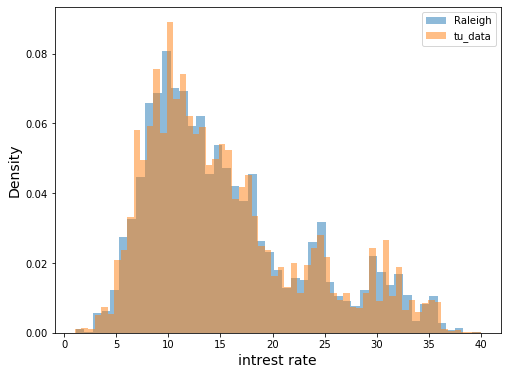

In [45]:
bins=round(len(enriched_raleigh['int_rate'].unique())**0.5)
bins1=round(len(tu_data['int_rate'].unique())**0.5)
plt.figure(figsize=(8,6))
plt.hist(enriched_raleigh['int_rate'], bins=bins, alpha=0.5, label="Raleigh",density=True)
plt.hist(tu_data['int_rate'], bins=bins1, alpha=0.5, label="tu_data",density=True)
plt.legend()
plt.xlabel("intrest rate", size=14)
plt.ylabel("Density", size=14)

Describe the interest rate distribution using `sns.distplot` in the Raleigh dataframe and in TU.

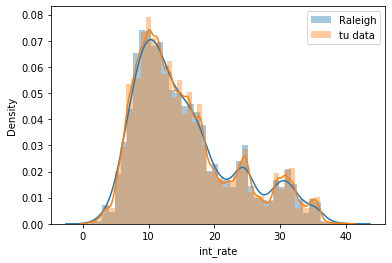

In [46]:
sns.distplot(enriched_raleigh['int_rate'],label='Raleigh')
sns.distplot(tu_data['int_rate'],label='tu data')
plt.legend()
plt.show()

Additionally, we want to make sure the credit scores are not visibly different in Raleigh from the general population, as this might mean that the data we obtained from the town might not be representative of the general popuation.

Create a histogram to describe the distribution of credit scores in the Raleigh sample and in the general population. Do the distributions look similar? How many bins did you use?

Text(0, 0.5, 'Density')

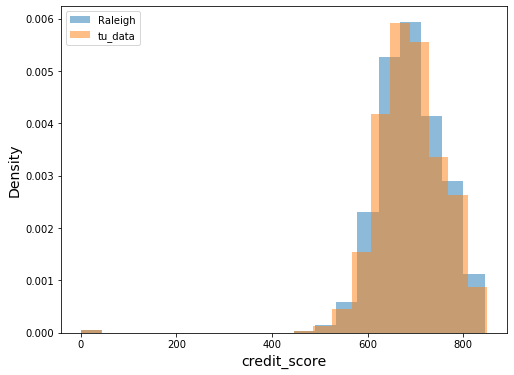

In [48]:
bins=round(len(enriched_raleigh['credit_score'].unique())**0.5)
bins1=round(len(tu_data['credit_score'].unique())**0.5)

plt.figure(figsize=(8,6))
plt.hist(enriched_raleigh['credit_score'], bins=bins, alpha=0.5, label="Raleigh",density=True)
plt.hist(tu_data['credit_score'], bins=bins1, alpha=0.5, label="tu_data",density=True)
plt.legend()
plt.xlabel("credit_score", size=14)
plt.ylabel("Density", size=14)

Describe the credit score distribution using `sns.distplot`  in the Raleigh dataframe and in TU.

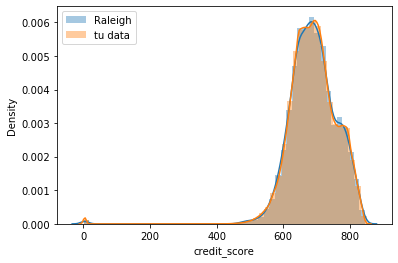

In [49]:
sns.distplot(enriched_raleigh['credit_score'],label='Raleigh')
sns.distplot(tu_data['credit_score'],label='tu data')
plt.legend()
plt.show()

Finally, check whether the loans in both datasets have similar distributions of term (i.e. the amount of months the borrower takes the loan for). What values of term exist in the data?

In [52]:
tu_data['listing_term'].value_counts()

36.0    542102
60.0    430621
Name: listing_term, dtype: int64

In [53]:
enriched_raleigh['listing_term'].value_counts()

36.0    4896
60.0    3896
Name: listing_term, dtype: int64

# CLT in action

One more thing before we start the test. Our goal is to check whether, for which we'll run some statistical test (you probably already know which) which checks if something belongs to a noraml distribution with some mean and some variance. But... is activation normally distributed in the Raliegh sample? 

#+2 points if you answer without plotting

*Answer:* No, activation follows a Bernolli distribution. 

The reason why we can assume normality is because we're checking averages of samples and we're relying on the Central Limit Theorem. We won't prove the theorem, but let's test it for a bit. 

Write a function which takes a pandas series S and a natural number n and creates a series of means of samples (with replacement) of n entries from S. Decide for yourself on the length of the output series. You can also use a different data structure if you find it more suitable as the output.

In [124]:
def clt(S, n, m=1000):
    indices = np.random.randint(len(S),size=(n,m))
    return pd.Series(S.values[indices].mean(axis=0))

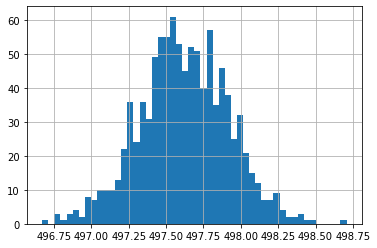

In [120]:
# example for clt:

S=pd.Series(np.random.randint(1000,size=10000))
clt(S, 1000000).hist(bins=50)

Optionally- also create a function which, given the same input as above, plots a histogram of the series of means, and also indicates the mean of this series.

In [125]:
def clt_with_plot(S, n,m=1000):
    res = clt(S,n,m)
    avg = res.mean()
    sns.distplot(res).set(title='The mean is {}'.format(avg))
    return res.mean()

503.18321086

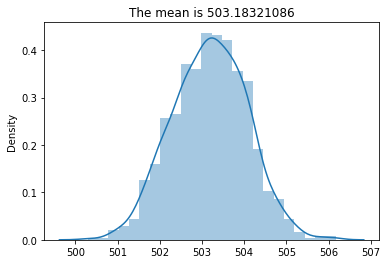

In [122]:
# example for clt_with_plot:

S=pd.Series(np.random.randint(1000,size=10000))
clt_with_plot(S, 100000)

Generate plots of the series of means of activation in Raleigh and in TU for n = 1, 2, 5, 10, 100, 1000 and 1e6, and indicate their means. Does the distribution approach a normal distribution as $n\to\infty$ in your opinion?

In [59]:
n_val = [1,2,5,10,100,1000,1000000]

S = raleigh_df_no_dup['offer_accepted']

interact(clt_with_plot,S=fixed(S) ,n=n_val);

interactive(children=(Dropdown(description='n', options=(1, 2, 5, 10, 100, 1000, 1000000), value=1), Output())…

Now that your fuction is ready, it's time to make it part of our infrastucture:
* Inside the `pagayapro` repo, create a branch called `feature/{your_user_name}/clt_tester/`.
* Create a file called `clt.py` inside `~/pagayapro/users/{user_name}/assignment1/` 
* Copy the two finctions you just created into the file.
* Push your file to `main`, open a PR and ask your mentor to review it. Once approved, rebase and merge.

In [61]:
from clt import clt_with_plot

# Statistical test 

As mentioned in the Notion doc, the activation in Raleigh before deployment was measured at 6.85%. In this section, you will run a test to check whether the activation in Raleigh is indeed different following the flyer program. 

Run a statistical test to check whether the current activation rate in Raleigh is different from 6,85%:
1. What are your hypotheses?
2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error? What is the power of your test?
3. Is the sample mean significantly different from the past value of 6.85?
4. Interpret your results. Can you declare the program as successful in increasing activation (what is the probability of wrongfully declaring it successful)?
5. Are there any other possible explanations for the change in activation that you observed? Discuss the possible drawbacks of our current test.

Use `proportions_ztestz` from `statsmodels.stats.proportion` in order to perform the test. Are your results significant?

2. Setting your confidence level at 95%:
 
     - what is the probability of an error of type I in your test? 
 
     The probability of type I error in our tet is 5%
 
     - What is the probability of a type II error? What is the power of your test?
    
    

3. Is the sample mean significantly different from the past value of 6.85?

In [65]:
stat, pval = proportions_ztest(raleigh_df_no_dup['offer_accepted'].sum(),len(raleigh_df_no_dup['offer_accepted']),value=0.0685)

In [66]:
pval

1.4005491742963572e-09

We get p-value almost equal to zero, therefore we reject $H_0$, according to which the mean is the same - i.e. the sample mean *is* significantly different from the past value.

4. Interpret your results. Can you declare the program as successful in increasing activation (what is the probability of wrongfully declaring it successful)?



5. Are there any other possible explanations for the change in activation that you observed? Discuss the possible drawbacks of our current test. Do you see any possible problems in your methodology? What other factors can explain the change in activation, if such a change exists?

    *Answer:* In our test we compared data from different times. The change in the mean activation might be caused by changes in economy, changes in how people percieve loans, etc. 

# A/b test

In order to isolate temporal and environmental effects on activation, we'll run an a/b test, comparing the activation rate in Raleigh to that of Lubbock, TX, another town in which Pagaya operates without a flyer program. 

The activation forms for Lubbock also appear in the `offers` subdirectory of the `ASSIGNMENT1_DATA` folder. Read all files from this folder whose name contains the substring 'lubbock', and create a dataframe of final offers called `lubbock_df`, drop unnecessary rows from it, and enrich it with TU features.

In [67]:
lubbock_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*lubbock*")
    )
)

In [68]:
lubbock_df= pd.concat(map(pd.read_csv,lubbock_forms))

In [69]:
lubbock_df_no_dup=lubbock_df.sort_values(by='offer_date').groupby('id').last()

In [70]:
lubbock_df_no_dup

,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
id,,,,,
00081387dcef0fab60c7f9f94669cc6df140531c9e0a55c0e98b55dc5aef08d6,35357872fbcfec327a4c7665f08a98f0dc55eb19969f36...,4070.0,8.24,False,2020-07-10
00090fdbe1fc33bf53dda546318c248cb6fe4299ad39dd9db2abd4c32ed2e152,6c98c998cb4bd242edbd55164eeed3927372264f8395b8...,5550.0,16.68,False,2020-06-02
000aa5e29eadd0bd7e2c9649d0ed986af4848895b6a4fa7883c67dd56b5b75ac,921cda1c86bc82347ea8168a894918f8ae857cdbbdb9a5...,25000.0,7.18,False,2019-06-19
001046cb99ae36567910bdd6fd907622cdc8aefb1689d66339fcb59353be46e2,0637e25695fcabdcec43d21364397793a169bd8b6977ed...,20000.0,6.68,False,2018-02-20
00176f09e7f3c4c864098d84a1f07e632fcce67f4d8d1b7ae08aabd5961227f3,1448249d369054a06a82acb4003d3daee61574935da0a8...,10000.0,8.99,False,2019-09-27
...,...,...,...,...,...
ffd1f19c3e14b4ba2c064010847e0c323bdc392af84a945ee91b0e9f58c16d4d,365577da66c826c4c6730cae6e46000806891e8a42a69e...,3000.0,18.36,False,2019-04-17
ffe0a054b953d3e19b166077d839dbc2807317446cbb47f0b49f764ce5cb23b9,fed3407c137d244faf74510485b480a6c6fc852b689bef...,5000.0,29.90,False,2020-05-15
ffe1669cce5b7b2f1cb43f6f44a0ab1a4e2ab73856f6d552d29f551daf460547,d88f12e6b0ba3b34cc1512216eb1694ac8e5386d681cbc...,12000.0,12.83,False,2019-10-30


What is the average interest rate in Lubbock? What is it among accepting borrowers?

In [72]:
# average interest rate in Lubbock
lubbock_df_no_dup['offered_interest_rate'].mean()

15.505397526501767

In [73]:
# average interest rate in Lubbock among acceting borrowers
lubbock_df_no_dup[lubbock_df_no_dup['offer_accepted']==True]['offered_interest_rate'].mean()

13.553895131086144

What is the average credit score in Lubbock? What is it among accepting borrowers?

In [74]:
enriched_lubbock = lubbock_df_no_dup.merge(tu_data,on=['id','sequence_num'])

In [76]:
enriched_lubbock.head()

,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
id,,,,,,,,,,,
00081387dcef0fab60c7f9f94669cc6df140531c9e0a55c0e98b55dc5aef08d6,35357872fbcfec327a4c7665f08a98f0dc55eb19969f36...,4070.0,8.24,False,2020-07-10,735,36.0,8.24,4070.0,128.0,TX
00090fdbe1fc33bf53dda546318c248cb6fe4299ad39dd9db2abd4c32ed2e152,6c98c998cb4bd242edbd55164eeed3927372264f8395b8...,5550.0,16.68,False,2020-06-02,636,36.0,16.68,5550.0,197.0,TX
000aa5e29eadd0bd7e2c9649d0ed986af4848895b6a4fa7883c67dd56b5b75ac,921cda1c86bc82347ea8168a894918f8ae857cdbbdb9a5...,25000.0,7.18,False,2019-06-19,664,36.0,7.18,25000.0,774.0,TX
001046cb99ae36567910bdd6fd907622cdc8aefb1689d66339fcb59353be46e2,0637e25695fcabdcec43d21364397793a169bd8b6977ed...,20000.0,6.68,False,2018-02-20,819,60.0,6.68,20000.0,393.0,TX
00176f09e7f3c4c864098d84a1f07e632fcce67f4d8d1b7ae08aabd5961227f3,1448249d369054a06a82acb4003d3daee61574935da0a8...,10000.0,8.99,False,2019-09-27,780,36.0,8.99,10000.0,318.0,TX


What is the average credit score of the clients? What is the average among clients who accepted the offer?

In [77]:
# average credit score of the client
enriched_lubbock['credit_score'].mean()

690.0338339222615

In [78]:
# average credit score of the client who accepted the offer
enriched_lubbock[enriched_lubbock['offer_accepted']]['credit_score'].mean()

730.5337078651686

What is the rate of activation in Lubbock?

In [79]:
# rate of activation in Lubbock
enriched_lubbock['offer_accepted'].mean()

0.04717314487632509

## Caution about a/b test 

Note that this is not a classical a/b test. Usually, in such a test, one creates two random subgroups from the general population and applies a manipulation to one of them in order to see if the manipulation had an effect. However, in this case, it is very complicated to isolate a random subgroup from any population and deploy the flyer program only on it.
Thus, due to production limitation, we have to make do with what we got.

In order to justify the use of an a/b test for this situation, we should at least verify that the borrower population in Lubbock and Raleigh seem as though they were randomly selected from the general population. We have actually already checked it for Raleigh above. Add TU features to the loan amount, interest rate, credit score and term comparisons and see if there any major differences between the three populations (Lubbock, Raleigh and TU).

Text(0, 0.5, 'Density')

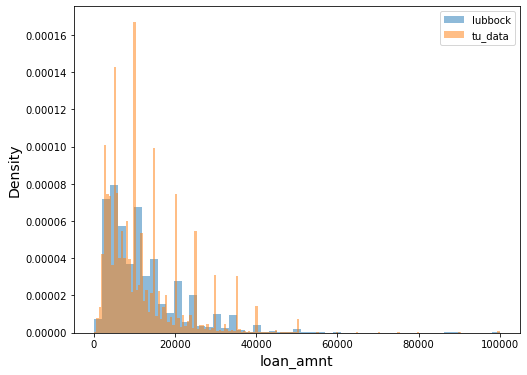

In [80]:
bins=round(len(enriched_lubbock['loan_amnt'].unique())**0.5)
bins1=round(len(tu_data['loan_amnt'].unique())**0.5)

plt.figure(figsize=(8,6))
plt.hist(enriched_lubbock['loan_amnt'], bins=bins, alpha=0.5, label="lubbock",density=True,range=(0,100000))
plt.hist(tu_data['loan_amnt'], bins=bins1, alpha=0.5, label="tu_data",density=True,range=(0,100000))
plt.legend()
plt.xlabel("loan_amnt", size=14)
plt.ylabel("Density", size=14)

Describe the loan amount distribution using `sns.distplot` in the Raleigh dataframe and in TU.

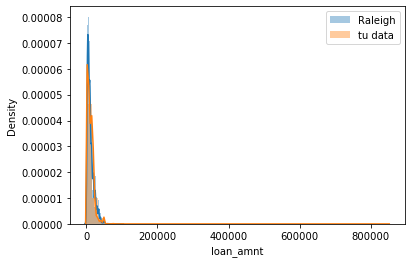

In [83]:
sns.distplot(enriched_lubbock['loan_amnt'],label='Raleigh')
sns.distplot(tu_data['loan_amnt'],label='tu data')
plt.legend()
plt.show()

We also want to verify that the offered interest rate in Raleigh seem similar to those in the general population. 
Create a histogram to describe the distribution of offered interest rates in Raleigh and interest rates in the general population. Do the distributions look similar?

Text(0, 0.5, 'Density')

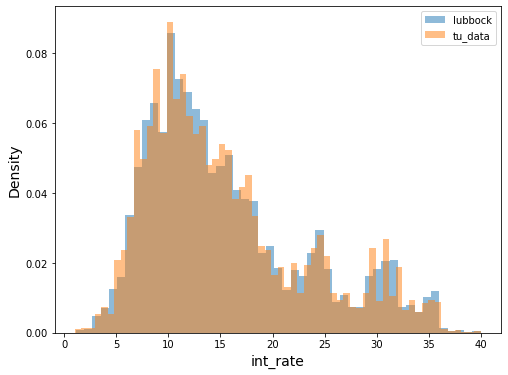

In [82]:
bins=round(len(enriched_lubbock['int_rate'].unique())**0.5)
bins1=round(len(tu_data['int_rate'].unique())**0.5)

plt.figure(figsize=(8,6))
plt.hist(enriched_lubbock['int_rate'], bins=bins, alpha=0.5, label="lubbock",density=True)
plt.hist(tu_data['int_rate'], bins=bins1, alpha=0.5, label="tu_data",density=True)
plt.legend()
plt.xlabel("int_rate", size=14)
plt.ylabel("Density", size=14)

Describe the interest rate distribution using `sns.distplot` in the Raleigh dataframe and in TU.

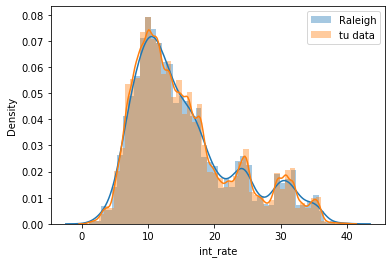

In [84]:
sns.distplot(enriched_lubbock['int_rate'],label='Raleigh')
sns.distplot(tu_data['int_rate'],label='tu data')
plt.legend()
plt.show()

Text(0, 0.5, 'Density')

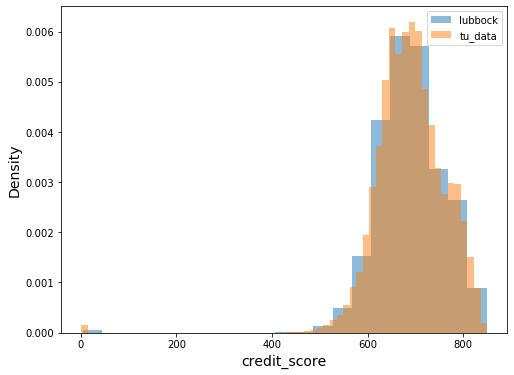

In [85]:
bins=round(len(enriched_lubbock['credit_score'].unique())**0.5)
bins=round(len(tu_data['credit_score'].unique())**0.5)

plt.figure(figsize=(8,6))
plt.hist(enriched_lubbock['credit_score'], bins=bins, alpha=0.5, label="lubbock",density=True)
plt.hist(tu_data['credit_score'], bins=bins1, alpha=0.5, label="tu_data",density=True)
plt.legend()
plt.xlabel("credit_score", size=14)
plt.ylabel("Density", size=14)

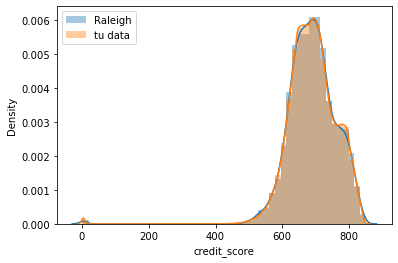

In [86]:
sns.distplot(enriched_lubbock['credit_score'],label='Raleigh')
sns.distplot(tu_data['credit_score'],label='tu data')
plt.legend()
plt.show()

Finally, check whether the loans in both datasets have similar distributions of term (i.e. the amount of months the borrower takes the loan for). What values of term exist in the data?

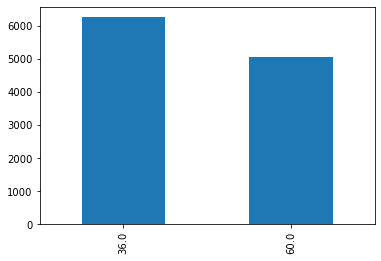

In [87]:
enriched_lubbock['listing_term'].value_counts().plot.bar()

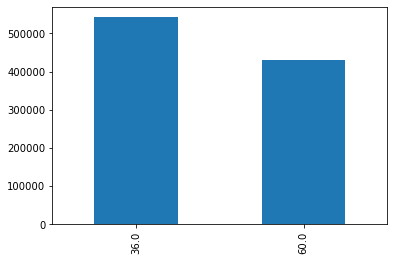

In [88]:
tu_data['listing_term'].value_counts().plot.bar()

## Performing the test

Use the function you created in the file `clt.py` to plot the series of means of activation in Raleigh and Lubbock for samples of size n= 1, 10, 1000 and 1e6, and compare the means of the two histograms. To they seem to converge to the same value?

In [91]:
n_val = [1,10,1000,1000000]
S = lubbock_df_no_dup['offer_accepted']

interact(clt_with_plot,S=fixed(S) ,n=n_val);

interactive(children=(Dropdown(description='n', options=(1, 10, 1000, 1000000), value=1), Output()), _dom_clas…

Apply a statistical test to see whether the activation rate in Raleigh, NC is significantly larger than Lubbock, TX. Clearly state and validate your test's assumption. 

1. What are your hypotheses?
2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error?
3. Are the two samples significantly different? 
4. Interpret your results. Can you declare the program as successful in increasing activation? What is the probability of wrongfully declaring it successful?

Use the `proportions_ztestz` function from `statsmodels.stats.proportion` to perform a comparison between the activation probability in Lubbock and in Raleigh. 

1. What are your hypotheses?

    Denote the mean of activation in Raleigh as $\mu_1$ and the mean of activation in Lubbock as $\mu_2$
    
    $H_0: \mu_1=\mu_2$, i.e. the activation probability did not change

    $H_1: \mu_1\not=\mu_2$, i.e. the activation probability changed
    

2. Setting your confidence level at 95%: what is the probability of an error of type I in your test?

    *Answer:* The probability of type I error in our tet is 5%

3. Are the two samples significantly different? 

In [92]:
sample_raleigh, sample_size_raleigh = (raleigh_df_no_dup['offer_accepted'].sum(),len(raleigh_df_no_dup['offer_accepted']))
sample_lubbock, sample_size_lubbock = (lubbock_df_no_dup['offer_accepted'].sum(),len(lubbock_df_no_dup['offer_accepted']))

successes = np.array([sample_raleigh, sample_lubbock])
samples = np.array([sample_size_raleigh, sample_size_lubbock])

stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
p_value

1.0951717760291721e-29

4. Interpret your results. Can you declare the program as successful in increasing activation? What is the probability of wrongfully declaring it successful? 

    *Answer:* According to the statistical test we performed, the probability to measure a proportion difference as extreme as we measurded or more is close to zero, specifically smaller than alpha. We therefore reject the null hypothesis, according to which the proportions are the same, with a confidense level of at least 95%, and declare the program as succesfull.

    The probability of wrongfully rejecting the null hypothesis is 5%.

# Testing for activation in sub-populations

Now that you applied the a/b test to the Lubbock and Raleigh datasets, it is now required that you make a similar comparison on different subsets of the data within various credit score and loan amount bins. To do so, let us first decide on how to segment our data.

You are asked to divide your data into 10 bins according to loan amount, and then divide each of those bins into 10 bins according to loan amount. The most staightforward way of doing this is by using the `pd.qcut` function; first dividing the data into 10 quantiles of credit score and then dividing each of these quantiles into 10 according to loan amount.

Divide your datasets as above and add two columns to your data which indicate the (credit_score, loan_amnt) of the bin.

In [95]:
tu_data['credit_score_bins'], bins1 = pd.qcut(tu_data['credit_score'], 10, retbins=True, labels=False)
tu_data['loan_amnt_bins'] = tu_data.groupby('credit_score_bins')['loan_amnt'].transform(lambda x: pd.qcut(x,10,labels=False))

In [96]:
tu_data.head()

,sequence_num,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state,credit_score_bins,loan_amnt_bins
id,,,,,,,,,
adf5219e4cb985352184eb7fa597737e4a9777f7354f7a8a58270da147792561,d0820401b209782dae4284b3dd96b41e08c3e8566fbb33...,814,36.0,7.86,5500.0,172.0,MI,9,2
0a0f130443af4c6597bb074942970eaddeb125d398e2cca42175c56befc8a171,2f05cd66cb998e5e55f6f296344b271b2b89b996c7c037...,800,36.0,7.91,20000.0,626.0,NM,9,7
4ba9c6a38b650ee06b8b88a48621bd363cdf611e63400c6fc4bbffbd1bf20c47,20bdbfaf0006db032d8a4176add08fd4ef45abfb17c474...,653,36.0,30.51,3674.0,157.0,SD,2,1
dae3a344292e07d4b8935a453c37aef01303f21b2f37ccbd1c4408f158533acb,53084498c6bf053a4d1cf309e1b8ec234e503bb1a3dd4e...,623,60.0,23.46,14056.0,400.0,NC,1,8
8af2ae2462d012e4d85aa687a16a4f5fb64525928235da43c795f73dc0cadd04,f750c4ecac12ae1c156998ed3dff3f46d2d19f37250074...,627,60.0,25.55,8659.0,257.0,TN,1,6


In [98]:
df_temp = raleigh_df_no_dup.merge(tu_data,on=['id','sequence_num'])
df_raleigh = df_temp.groupby(['credit_score_bins','loan_amnt_bins'])['offer_accepted'].agg(['sum','size','mean'])
df_raleigh

sum  size      mean
credit_score_bins loan_amnt_bins                     
0                 0                14   112  0.125000
                  1                12    86  0.139535
                  2                 8    79  0.101266
                  3                 3    78  0.038462
                  4                 8    95  0.084211
...                               ...   ...       ...
9                 5                21   115  0.182609
                  6                 8    35  0.228571
                  7                 9    83  0.108434
                  8                20   109  0.183486
                  9                16    69  0.231884

[100 rows x 3 columns]

In [99]:
df_temp = lubbock_df_no_dup.merge(tu_data,on=['id','sequence_num'])
df_lubbock = df_temp.groupby(['credit_score_bins','loan_amnt_bins'])['offer_accepted'].agg(['sum','size','mean'])
df_lubbock.head(12)

sum  size      mean
credit_score_bins loan_amnt_bins                     
0                 0                 2   141  0.014184
                  1                 2   104  0.019231
                  2                 1   114  0.008772
                  3                 1   108  0.009259
                  4                 4   106  0.037736
                  5                 1   110  0.009091
                  6                 0   128  0.000000
                  7                 4   125  0.032000
                  8                 2    83  0.024096
                  9                 1   105  0.009524
1                 0                 3   125  0.024000
                  1                 4   107  0.037383

Run an a/b test on each of the bins in your data and create a $10\times 10$ table containing the $p$ value of each test.

In [109]:
p_values = []
for i in range(100):
    
    sample_raleigh, sample_size_raleigh = (df_raleigh.iloc[i,0],df_raleigh.iloc[i,1])
    sample_lubbock, sample_size_lubbock = (df_lubbock.iloc[i,0],df_lubbock.iloc[i,1])

    successes = np.array([sample_raleigh, sample_lubbock])
    samples = np.array([sample_size_raleigh, sample_size_lubbock])
    stat, p_value = proportions_ztest(count=successes, nobs=samples,alternative='two-sided')
    p_values.append(p_value)

p_values = np.array(p_values).reshape((10,10))
p_values

array([[3.21855828e-04, 1.58101405e-03, 2.73016445e-03, 1.75489715e-01,
        1.65022071e-01, 1.35193554e-03, 1.34648972e-04, 1.24310847e-01,
        1.23781831e-05, 7.10407871e-03],
       [4.05691976e-03, 7.51837388e-01, 6.28241008e-01, 2.63883688e-01,
        3.65331190e-02, 2.52862965e-03, 3.00411025e-02, 4.61219364e-01,
        4.17351694e-01, 3.46891744e-01],
       [2.11963569e-01, 1.59184605e-01, 8.28161641e-01, 3.16909743e-01,
        4.99173094e-01, 1.58750724e-02, 5.16752392e-01, 7.27001087e-02,
        8.93729099e-02, 4.48061704e-02],
       [3.56773776e-01, 1.78971455e-01, 9.42214396e-02, 2.82789841e-02,
        7.62259200e-01, 1.91394734e-01, 8.12668004e-01, 4.82498071e-02,
        7.40370275e-01, 6.92417465e-01],
       [6.12373469e-01, 6.01717296e-02, 3.78084417e-01, 8.03454698e-02,
        4.64645986e-02, 2.52880989e-01, 4.45737865e-01,            nan,
        6.71785823e-01, 3.57352937e-01],
       [4.44861338e-04, 8.63516431e-02, 4.27846435e-03, 1.05480326e-01,
   

Use the [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to represent your table as a heatmap. You can also use it on a suitable table of boolean values to get a more robus representation of which experiments turned out significant.

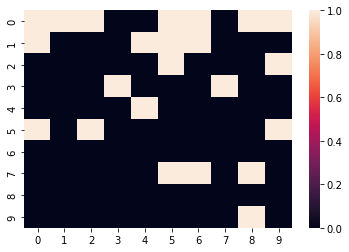

In [110]:
sns.heatmap(p_values<=0.05)

What is the probability of falsely rejecting the null hypothesis in each cell? What is the probability of falsely rejecting the null hypothesis in at least one of the cells (i.e. what is the **family wise error rate**)?

In other words, given that we made $m$ experiments, with confidence level $\alpha$, what is the probabilty $\mathbb{P}\left(\bigcup_i X_i \le q_{\alpha}\right)$? 

_Note_: you may assume that sampling from different bins are independent.

- The probabilty is:

$\mathbb{P}(\bigcup_i X_i \leq q_\alpha) = 1 - \mathbb{P}(\bigcap_i X_i > q_\alpha) = 1 - \prod_i\mathbb{P}(X_i > q_\alpha) = 1- \prod_i \alpha = 1- \alpha^m$ 

In our case it is almost 1, which means we almost surely falsely reject the null hypothesis in at least one of the cells.

## Bonferroni correction 

One way of assuring that your FWER remains below $\alpha=0.05$ is to apply a <a href="https://en.wikipedia.org/wiki/Bonferroni_correction">**Bonferroni correction**</a>. This means that we set the signficance level of each individual test to $\alpha/m$, where $m=100$ is the number of tests (see, e.g., Wikipedia for an explanation). 

Use a Bonferroni correction on your segmented a/b test and output a $10\times10$ table of boolean values, indicating which test gave a significant result under this correction.

In [111]:
p_values<0.0005

array([[ True, False, False, False, False, False,  True, False,  True,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [ True, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])

How many of your tests came out significant under this correction?

- 0

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

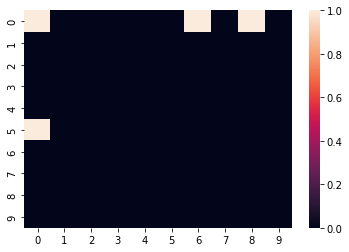

In [112]:
sns.heatmap(p_values<=0.0005,vmin = 0, vmax=1)

## BH correction 

The Bonferroni correction is often criticized for being too restrictive, as you probably noticed in the last subsection. A more commonly used method for correcting $\alpha$ values is the Benjamini-Hochberg method. You can <a href="https://www.youtube.com/watch?v=K8LQSvtjcEo">check out the quest</a> for a nice explanation about it.

Start by arranging the $p$-values of your original test as a series and listing them in ascending order. You can use the `pd.DataFrame.stack` and `pd.Series.sort_values` methods.

In [113]:
ind = np.argsort(p_values.reshape(-1))
p_values_sorted = p_values.reshape(-1)[ind]

Plot your sorted $p$-values

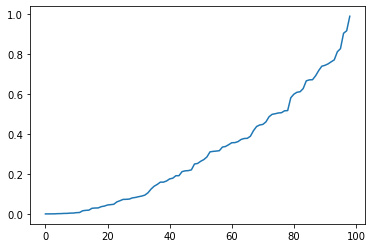

In [114]:
plt.plot(p_values_sorted)

In [115]:
p_values_sorted

array([1.23781831e-05, 1.34648972e-04, 3.21855828e-04, 4.44861338e-04,
       1.35193554e-03, 1.58101405e-03, 2.52862965e-03, 2.73016445e-03,
       4.05691976e-03, 4.27846435e-03, 6.33752788e-03, 7.10407871e-03,
       1.58750724e-02, 1.78939231e-02, 1.88836572e-02, 2.82789841e-02,
       2.95795311e-02, 3.00411025e-02, 3.65331190e-02, 3.92404193e-02,
       4.48061704e-02, 4.64645986e-02, 4.82498071e-02, 6.01717296e-02,
       6.61396548e-02, 7.27001087e-02, 7.31597839e-02, 7.43474109e-02,
       8.03454698e-02, 8.26114831e-02, 8.63516431e-02, 8.93729099e-02,
       9.42214396e-02, 1.05480326e-01, 1.24310847e-01, 1.38723470e-01,
       1.47688532e-01, 1.59184605e-01, 1.59248892e-01, 1.65022071e-01,
       1.75489715e-01, 1.78971455e-01, 1.91394734e-01, 1.91605257e-01,
       2.11963569e-01, 2.15893014e-01, 2.16960497e-01, 2.20816490e-01,
       2.50165272e-01, 2.52880989e-01, 2.63883688e-01, 2.72242323e-01,
       2.85468675e-01, 3.11056524e-01, 3.13415736e-01, 3.14874753e-01,
      

For each entry of the new series, compute the value compute the value $\frac{i}{m}\cdot\alpha$, where $i$ is the ordinal place of the entry (i.e. 1,2,...len(series)), $m=100$ and $\alpha=0.05$ as above. Add a plot of these values to your $p$-values plot.

In [116]:
values = np.arange(100) * 0.05 / 100

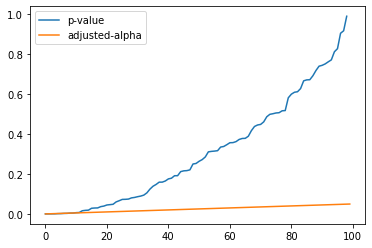

In [117]:
plt.plot(p_values_sorted, label='p-value')
plt.plot(values, label='adjusted-alpha')
plt.legend()

Find the largest index $i$ for which the $p$-value in the $i$-th place in the series is smaller than $\frac{i}{m}\cdot\alpha$. That is- the last index in the plot you just created where the $p$-values line lies below the _adjusted_-$\alpha$ line.

In [123]:
fixed_alpha_arr = p_values_sorted[p_values_sorted < values]
print(fixed_alpha_arr)
fixed_alpha = 0
if len(fixed_alpha_arr)==0:
    fixed_alpha = p_values_sorted[0]
else:
    fixed_alpha=fixed_alpha_arr[-1]
fixed_alpha

[0.00013465 0.00032186 0.00044486 0.00135194 0.00158101 0.00252863
 0.00273016 0.00427846]


0.004278464353322961

Reject the null hypothesis for all test before and including this index, and accept it for all others. Reformat your table into a $10\times 10$ dataframe; for which bins did we get a significant result in the corrected test?

In [121]:
p_values < fixed_alpha

array([[ True,  True,  True, False, False,  True,  True, False,  True,
        False],
       [ True, False, False, False, False,  True, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [ True, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

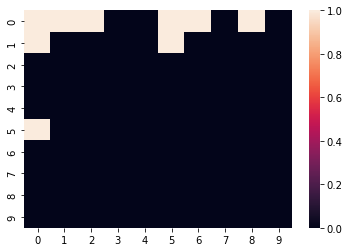

In [122]:
sns.heatmap(p_values < fixed_alpha,vmin = 0, vmax=1)

### Validating your results

You can validate your results (for both corrections) using the <a href= "https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html">`statsmodels.stats.multitest.multipletests`</a> package.